In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import normal, multivariate_normal, binomial
from sklearn.preprocessing import StandardScaler 

In [102]:
def generate_data(nb_obs=1000, nb_feat=9, tau=0, scenario=1, is_homo=True, random_state=1234):
    # from https://arxiv.org/pdf/2204.10969
    np.random.seed(random_state)
    X = multivariate_normal(mean = np.zeros(nb_feat), cov=np.diag(np.ones(nb_feat)), size=nb_obs)
    W1 = (np.exp(X[:,0] / 2)).reshape(-1,1)
    W2 = (np.exp(X[:,1] / 3)).reshape(-1,1)
    W3 = (X[:,2]**2).reshape(-1,1)
    W4 = (X[:,3]**2).reshape(-1,1)
    W5 = (X[:,4]).reshape(-1,1)
    W6 = (X[:,5]).reshape(-1,1)
    W7 = (X[:,6] + X[:,7]).reshape(-1,1)
    W8 = (X[:,6]**2 + X[:,7]**2).reshape(-1,1)
    W9 = (X[:,8]**3).reshape(-1,1)

    columns = ['W1','W2','W3','W4','W5','W6','W7','W8','W9']
    W = pd.DataFrame(np.concatenate((W1, W2, W3, W4, W5, W6, W7, W8, W9), axis=1), columns=columns)
    # standardize W
    scaler = StandardScaler()  
    W_std = pd.DataFrame(scaler.fit_transform(W), columns=columns)

    # generate logits
    if (scenario == 1):
        # normal ps
        ps_logit = (-3 + -1*W_std.W1 + 2*W_std.W2 - 3*W_std.W3 + 3*W_std.W4 + 2*W_std.W5 + W_std.W6) / 15
    elif (scenario == 2):
        # moderate ps
        ps_logit = (-3 + -1*W_std.W1 + 2*W_std.W2 - 3*W_std.W3 + 3*W_std.W4 + 2*W_std.W5 + W_std.W6) / 10
    elif (scenario == 3):
        # extreme ps
        ps_logit = (-3 + -1*W_std.W1 + 2*W_std.W2 - 3*W_std.W3 + 3*W_std.W4 + 2*W_std.W5 + W_std.W6) / 5
    else: 
        # more extreme
        ps_logit = (-8*W_std.W1 + 1.5*W_std.W2 + 0.5*W_std.W3 - 0.5*W_std.W4 + 2.5*W_std.W5 - 0.5*W_std.W6) / 5

    # compute propensity scores
    ps = 1 / (1 + np.exp(-ps_logit))

    # generate treatment
    A = binomial(n=1, p=ps, size=nb_obs)

    # genrate potential outcomes
    Y0 = -2 + 1.5*W_std.W1 - 2*W_std.W2 + 1.5*W_std.W3 + 2.5*W_std.W7 - W_std.W8 + W_std.W9 + normal(nb_obs)
    if (is_homo):
        Y1 = Y0 + tau
    else:
        # hetero
        Y1 = Y0 + tau + 5*W_std.W1 + 3*W_std.W3 + 2*W_std.W1*W_std.W3

    # generate observed outcomes
    Y = Y1 * A + Y0 * (1 - A)
    
    return Y, A, Y0, Y1, ps, ps_logit, X, W

In [307]:
y, treat, _, _, ps, _, X, _ = generate_data(nb_obs=10000, scenario=1)

In [104]:
from sklearn.ensemble import RandomForestClassifier

In [312]:
X[:,0:3].shape

(10000, 3)

In [313]:
clf = RandomForestClassifier(max_depth=4, random_state=0)
clf.fit(X[:,0:3], treat)

RandomForestClassifier(max_depth=4, random_state=0)

In [315]:
gps = clf.predict_proba(X[:,0:3])[:,1]

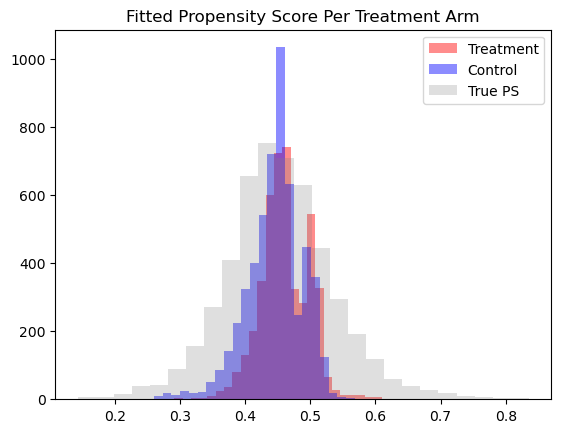

In [316]:
plt.hist(gps[treat>0], bins=25, alpha=0.45, color='red') 
plt.hist(gps[(1-treat)>0], bins=25, alpha=0.45, color='blue') 
plt.hist(ps.sample(5000), bins=25, alpha=0.25, color='grey')
plt.title("Fitted Propensity Score Per Treatment Arm") 
  
plt.legend(['Treatment',  
            'Control',
           'True PS']) 
  
plt.show() 

In [291]:
max_gps = gps[(1-treat)>0].max()
min_gps = gps[treat>0].min()
index = (gps > min_gps) & (gps < max_gps)

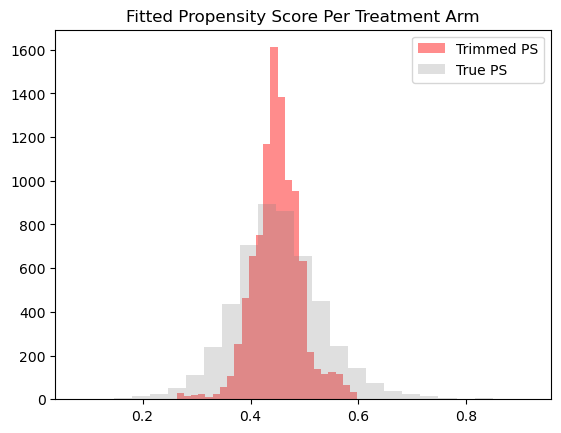

In [292]:
plt.hist(gps[index], bins=25, alpha=0.45, color='red') 
plt.hist(ps.sample(5000), bins=25, alpha=0.25, color='grey')
plt.title("Fitted Propensity Score Per Treatment Arm") 
  
plt.legend(['Trimmed PS', 'True PS']) 
  
plt.show() 

In [194]:
features_without_gps = np.concatenate((X, treat.reshape(-1,1)), axis=1)
features_with_gps = np.concatenate((X, treat.reshape(-1,1), gps.reshape(-1,1)), axis=1)

# features with true propensity score
features_with_ps = np.concatenate((X, treat.reshape(-1,1), ps.values.reshape(-1,1)), axis=1)

In [195]:
# features = pd.DataFrame(features_without_gps, columns=['X1','X2','X3','X4','X5','X6','X7','X8','X9', 'Treatment'])
features = pd.DataFrame(features_with_gps, columns=['X1','X2','X3','X4','X5','X6','X7','X8','X9', 'Treatment', 'GPS'])
# features = pd.DataFrame(features_with_ps, columns=['X1','X2','X3','X4','X5','X6','X7','X8','X9', 'Treatment', 'PS'])

In [146]:
# %pip install statsmodels
import statsmodels.api as sm

In [196]:
features = sm.add_constant(features)
model = sm.OLS(y, features)
results = model.fit()
results.params

const        10011.068477
X1               1.119897
X2              -1.388327
X3               0.164956
X4              -0.077876
X5               0.446787
X6               0.066655
X7               1.788932
X8               1.742559
X9               0.765101
Treatment        0.145906
GPS            -30.897375
dtype: float64

0.1459063793038311

In [197]:
# scenario1 : without GPS in the model, we get ATE = -0.3272
# with GPS in the model, we get ATE = 0.1459
# with true PS in the model, we get ATE = -0.0269

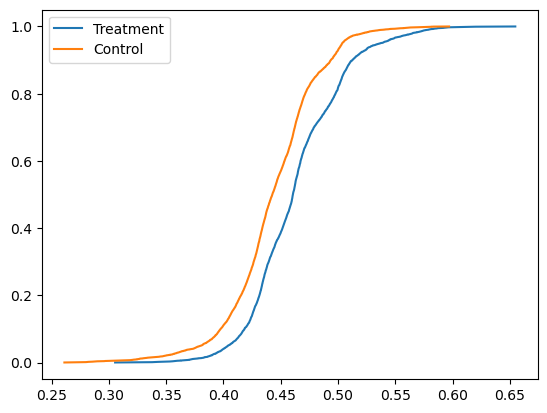

In [234]:
from statsmodels.distributions.empirical_distribution import ECDF

gps_treated = gps[treat>0]
gps_control = gps[(1-treat)>0]

# fit a cdf
ecdf_treated = ECDF(gps_treated)
ecdf_control = ECDF(gps_control)


plt.plot(ecdf_treated.x, ecdf_treated.y)
plt.plot(ecdf_control.x, ecdf_control.y)
plt.legend(['Treatment', 'Control'])

In [273]:
# pdf_treated = np.gradient(ecdf_treated.y, ecdf_treated.x)
# plt.plot(ecdf_treated.x, pdf_treated)
# pdf_treated

# pdf_control = np.gradient(ecdf_control.y, ecdf_control.x)
# plt.plot(ecdf_control.x, pdf_control)
# pdf_control

In [303]:
ate_gps = []
ate_ps = []
ate_without_gps = []

for k in np.arange(10):
    print(k)
    y, treat, _, _, ps, _, X, _ = generate_data(nb_obs=10000, scenario=3, random_state=k)
    clf = RandomForestClassifier(max_depth=4, random_state=0)
    clf.fit(X, treat)
    gps = clf.predict_proba(X)[:,1]
    features_with_gps = np.concatenate((X, treat.reshape(-1,1), gps.reshape(-1,1)), axis=1)
    features = pd.DataFrame(features_with_gps, columns=['X1','X2','X3','X4','X5','X6','X7','X8','X9', 'Treatment', 'GPS'])
    features = sm.add_constant(features)
    model = sm.OLS(y, features)
    results = model.fit()
    ate_gps.append(results.params.Treatment)

    features_with_ps = np.concatenate((X, treat.reshape(-1,1), ps.values.reshape(-1,1)), axis=1)
    features = pd.DataFrame(features_with_ps, columns=['X1','X2','X3','X4','X5','X6','X7','X8','X9', 'Treatment', 'PS'])
    features = sm.add_constant(features)
    model = sm.OLS(y, features)
    results = model.fit()
    ate_ps.append(results.params.Treatment)
    
    features_without_gps = np.concatenate((X, treat.reshape(-1,1)), axis=1)
    features = pd.DataFrame(features_without_gps, columns=['X1','X2','X3','X4','X5','X6','X7','X8','X9', 'Treatment'])
    features = sm.add_constant(features)
    model = sm.OLS(y, features)
    results = model.fit()
    ate_without_gps.append(results.params.Treatment)

0
1
2
3
4
5
6
7
8
9


In [304]:
np.mean(ate_gps)
#0.10786807564638785

-0.2716809178581926

In [305]:
np.mean(ate_ps)
#0.008014561205689219

0.009580382888636052

In [306]:
np.mean(ate_without_gps)
#-0.3022102017219261

-0.6780915343731241

In [301]:
ate_trimming_gps = []

for k in np.arange(10):
    print(k)
    y, treat, _, _, ps, _, X, _ = generate_data(nb_obs=10000, scenario=3, random_state=k)
    clf = RandomForestClassifier(max_depth=4, random_state=0)
    clf.fit(X, treat)
    gps = clf.predict_proba(X)[:,1]
    features_with_gps = np.concatenate((X, treat.reshape(-1,1), gps.reshape(-1,1)), axis=1)
    features = pd.DataFrame(features_with_gps, columns=['X1','X2','X3','X4','X5','X6','X7','X8','X9', 'Treatment', 'GPS'])
    
    features = sm.add_constant(features)
    
    max_gps = gps[(1-treat)>0].max()
    min_gps = gps[treat>0].min()
    
    index = (gps > min_gps) & (gps < max_gps)
    print(index.sum())
    model = sm.OLS(y.loc[index], features.loc[index])
    results = model.fit()
    ate_trimming_gps.append(results.params.Treatment)

0
9947
1
9935
2
9906
3
9734
4
9903
5
9906
6
9898
7
9948
8
9966
9
9969


In [302]:
np.mean(ate_trimming_gps)
#0.10815406875029403

-0.2721953567952431